In [1]:
# import the libraries
import cv2
import numpy as np
import pylab

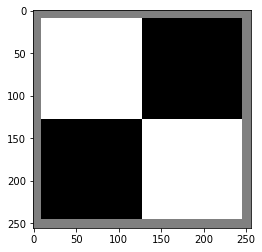

In [2]:
# load the image and convert it to grey
img = cv2.imread('ps1-input0.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
pylab.imshow(gray,cmap=pylab.gray())
pylab.show()

Question 1.a:
---------------
apply the canny edge filter on the image.
*note:* as this image don't have any noise, we don't need to add gaussian blur

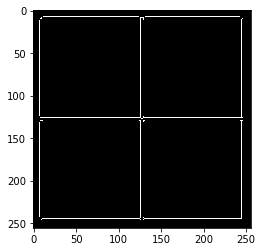

In [3]:
# apply canny edge detector
img1 = cv2.GaussianBlur( src=gray, ksize=(5,5), sigmaX=2, sigmaY=2, borderType=cv2.BORDER_REFLECT)
edges = cv2.Canny(gray,50,100,apertureSize = 7)
pylab.imshow(edges,cmap=pylab.gray())
pylab.show()

Question 2:
-------------
Write a Hough method for finding lines.

In [4]:
# hough method parameters
N = 100 # number of subdivision for theta and d

note that as the picture has no noise at all, we can pick N = sqrt(256^2 + 256^2) wich gives us a 1px resolution

In [5]:
def get_H_pos(d, dmax):
    """
    return the column corresponding to d in H
    """
    return int((d + dmax) * N/(2*dmax))

def get_vote(img, N=100, dmax=None):
    """
    apply hough filter on the edges images
    """
    if dmax==None:
        dmax = np.math.sqrt(img.shape[0]**2+img.shape[1]**2)
    H = np.zeros((N,N))
    edge_points = np.argwhere(img>1)
    for point in edge_points:
        for theta_bin in range(0, N):
            theta = theta_bin*np.math.pi/N
            d = point[0] * np.math.cos(theta) - point[1] * np.math.sin(theta)
            d_bin = get_H_pos(d, dmax)
            H[d_bin,theta_bin] = H[d_bin,theta_bin] + 1
    return H

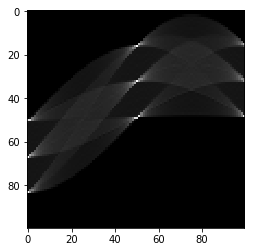

In [6]:
# apply hough algorithm
H = get_vote(edges, N)
# print hough transform
maximum = np.max(H)
hough_img = np.vectorize(lambda x: int(255*x/ maximum))(H)
pylab.imshow(hough_img, cmap=pylab.gray())
pylab.show()

as you can see there are 3 bright spots with the same theta=pi/2 there is also 3 bright sport with theta=pi (or 0)

In [7]:
# save picture
cv2.imwrite("ps1-2-1.jpg", hough_img)

True

now we are able to create the accumulator, we need to extract edges from it.
First let's define some utility functions:

In [8]:
def remove_feature(img, d_bin, theta_bin, dmax):
    """
    utility function that remove the pixel that lead to a given feature
    @param img: the image where you want to remove pixels
    @param d_bin theta_bin: the feature
    """
    (xmax,ymax) = img.shape
    for x in range(xmax):
        for y in range(ymax):
            theta = theta_bin*np.math.pi/N
            expected_d = x * np.math.cos(theta) - y * np.math.sin(theta)
            expected_d_bin = get_H_pos(expected_d, dmax)
            if expected_d_bin == d_bin:
                img[x,y] = 0 # remove the pixel
    return img

def convert_bins(d_bin, theta_bin, dmax, N):
    d = (d_bin*2*dmax/N)-dmax
    theta = theta_bin*np.math.pi/N
    return (d, theta)

In [9]:
def polar_features_extract(edges, N=100, minimum_votes=50):
    """
    return the list of polar coordinates corresponding to the lines extracted by hough filter
    @param edges: the image of the edges obtained by canny filter
    @param N: the resolution param ( number of bins ) * accuracy of lines localization *
    @param: minimum_votes: the minimal number of votes needed to be considered as feature * depth of the search *
    """
    # initialize algorithm
    remaining_edges = edges.copy()
    dmax = np.math.sqrt(img.shape[0]**2+img.shape[1]**2)
    H = get_vote(edges, N, dmax)
    maximum = np.max(H)
    bin_features = []
    features = []
    while maximum > minimum_votes:
        # add the maximum (ie. line) to the list of features
        new_features = np.argwhere(H==maximum)
        for (d_bin, theta_bin) in new_features:
            bin_features.insert(0, (d_bin, theta_bin))
            # remove the corresponding points from the original image
            remaining_edges = remove_feature(remaining_edges, d_bin, theta_bin, dmax)
        # recompute accumulator and maxima
        H = get_vote(remaining_edges, N)
        maximum = np.max(H)
    for (d_bin, theta_bin) in bin_features:
        features.insert(0,convert_bins(d_bin, theta_bin, dmax, N))
    return features

In [10]:
def draw_feature(img, feature):
    pass

In [11]:
polar_features = polar_features_extract(edges)